In [5]:
from __future__ import print_function
import glob, itertools, os, subprocess, re
import sys, time, tqdm, itertools, socket
import mdtraj as md
import msmbuilder.utils
import numpy as np
import itertools
from itertools import groupby, count
import matplotlib
%matplotlib inline
# Script: matplotlib.use('Agg')  | Notebook: %matplotlib inline
from matplotlib import cm
from matplotlib import pyplot as plt
from matplotlib.lines import Line2D
from msmbuilder.cluster import KCenters, KMeans, KMedoids
from msmbuilder.decomposition import tICA
from msmbuilder.featurizer import AtomPairsFeaturizer
from msmbuilder.msm import ContinuousTimeMSM, implied_timescales, MarkovStateModel
from operator import itemgetter
from sklearn.externals import joblib
from sklearn.pipeline import Pipeline
#from pymbar import MBAR
from pyemma.thermo import mbar

'''This script has lots of functionality and is based on analyzing Gromacs trajectories. A list of trajectory
   files is given as trajectory_files, as well as a general structure file. Other structure files should contain
   the same name as the corresponding trajectory file, e.g. traj_001.trr traj_001.gro.
'''

# this project represents a spiroligomer (1) from https://doi.org/10.1371/journal.pone.0045948
# bound to MDM2 (PDB: 1ycr)
# these runs represent the 20 ensembles: lam = false, d = {0.1, 2.0, 0.1}

# featurization parameters
project_title = 'PROJ14101' # creates sub-directory
structure_file = '%s/xtc.gro'%project_title
runs = len(glob.glob('%s/traj_data/RUN*'%project_title))
clones = max([len(glob.glob('%s/traj_data/RUN%d/*'%(project_title,x))) for x in range(runs)])
md_time_step = 0.02 # time in ns that trajectory files are saved (nstxtcout)
equil_time = 1. # time in ns to remove from beginning of each clone
subsampled_time_step = 0.5 # preferred subsampled time-step in ns
stride = int(subsampled_time_step / md_time_step) # time step stride for sub-sampling
equil_steps = int(equil_time / md_time_step) # time steps to be removed from start
custom_residues = ['B1A','B1B','B2A','B2B','B2C','B2D','B2E','B3A','B3B']
custom_residues += ['B4A','B4B','B4C','B4D','B5A','B5B','B5C','B6A'] # for spiroligomers
custom_residues += ['1MQ','20Q','20U','I18','I31','K23','NUT','YIN'] # for nutlins

# tICA/MSM parameters
tica_lagtime = 10 # determine from implied timescales / GMRQ
n_components = 8 # how many tICs to compute
n_clusters = 100 # denotes number of microstates
n_timescales = n_components # plot all eigenvalues --> timescales
lagtimes = np.array([1,2,4,8,16,32,64,128,256,512,1024]) # log scale
cluster_method = 'kcenters' # 'kcenters/kmeans/kmedoids'
all_ticas = list(itertools.permutations(range(1,n_components+1), 2)) # all combinations
all_ticas = [[1,2]] # override: just show analysis for first two components
cluster_percentage_cutoff = n_clusters/64 # clusters with a relative population less than this
                              # number will not be labeled on plot i.e. 0 : all clusters labeled
    
# MBAR/TRAM parameters
K = runs # sets n_ensembles = n_runs
L = K # secondary ensemble count for MBAR
kspring_k = [200.0] * K # spring constant for each ensemble in kJ/mol/nm^2
equilibrium_distances = [0.1+0.1*k for k in range(K)]
protein_anchor = 555
restrained_distance_indices = [[[555,'COM']]]*K # which distances are restrained for each
restrained_distance_labels = ['d555-ligand_COM']*K # restraint labels for plots
temperature = 300.0 # in K
T_k = np.ones(K,float)*temperature # This simulation uses only 300K sampling
kB = 1.381e-23 * 6.022e23 / 1000.0 # Boltzmann constant in kJ/mol/K
beta = 1.0 / (kB * temperature) # inverse temperature of simulations (in 1/(kJ/mol))

print('Current Directory: %s'%os.getcwd())

Current Directory: /media/tug27224/My Passport/analysis


In [26]:
def compute_distances():
    
    """Calculate pair-wise distance features and save as .npy files.
       Index selection is done within the function.
       Feature labels are returned to match tICA components back to the features that make them up.
    """
    
    print("\nCalculating distances...")
    
    if not os.path.exists(project_title + '/features'):
        os.mkdir(project_title + '/features')
    
    verbose = False
    protein_residues = range(50,64) # residue indices for MDM2 binding helix
    trajectory_files = []
    skipped = 0
    
    for run in range(runs):
        trajectory_files += sorted(glob.glob('%s/traj_data/RUN%d/*xtc'%(project_title,run)))

    for i in tqdm.tqdm_notebook(range(len(trajectory_files))): # For each trajectory file
        traj = md.load(trajectory_files[i], top=structure_file)
        if verbose:
            print("Loaded " + trajectory_files[i] + " with top: " + structure_file)

        # custom residue definition
        custom_residues = ['1MQ','20Q','20U','I18','I31','NUT','YIN','K23']
        custom_residues += ['B1A','B1B','B2A','B2B','B2C','B2D','B2E','B3A','B3B']
        custom_residues += ['B4A','B4B','B4C','B4D','B5A','B5B','B5C','B6A']

        # index selection
        protein_indices = [ a.index for a in traj.topology.atoms if a.name in ['CA'] and a.residue.index in protein_residues and a.residue.name not in custom_residues]
        ligand_indices = [ a.index for a in traj.topology.atoms if a.element.symbol == 'C' and a.residue.name in custom_residues]

        # transform indices into distances and save
        pairs = list(itertools.product(protein_indices[::2], ligand_indices[::3]))
        
        # ensure that number of features is greater than the length of the strided
        # trajectory, so the autocorrelation matrix is guaranteed to be positive definite.
        if len(pairs) > len(traj[equil_steps:][::stride]):
            if verbose:
                print("Number of features (%d) exceeds strided trajectory length (%d). Skipping.\n" %(len(pairs),len(traj)/stride))
            skipped += 1
            continue
        
        # these are returned and are useful for mapping tICA components back to the 
        # atoms and residues that correspond to each feature.
        feature_labels = [[[str(traj.topology.atom(j[0]).residue.index) +
                            traj.topology.atom(j[0]).residue.name,traj.topology.atom(j[0]).name],
                          [str(traj.topology.atom(j[1]).residue.index) + 
                           traj.topology.atom(j[1]).residue.name,traj.topology.atom(j[1]).name]] for j in pairs]
        
        features = AtomPairsFeaturizer(pairs)
        transformed_data = features.fit_transform(traj[equil_steps:][::stride])
        
        for j in range(len(transformed_data)):
            transformed_data[j] = transformed_data[j][0]
        
        if verbose:
            print("Saved %d pair-wise distance features over %d frames.\n" %(len(pairs),len(transformed_data)))
        feature_file = re.sub('.xtc','',re.sub('traj_data/RUN.*/','features/',trajectory_files[i]))
        np.save(feature_file, transformed_data)
    
    print('Skipped %d/%d (%.3f%%) trajectories because number of features exceeded strided frames.'%(skipped,len(trajectory_files),float(100*skipped/len(trajectory_files))))
    print('If this number seems too high, decrease number of features or decrease stride.')
    return feature_labels

In [16]:
def compute_tica_components():
          
    '''Load in the features, calculate a given number of tICA components (tica_components) given a
       lagtime (lag_time), and save tICA coordinates and eigenvector data. It then creates and populates
       a list for each desired component, clusters the data, saving normalized populations as populations.dat
       and saving each cluster center as a .pdb. tICA plots are created and saved, and implied timescales are
       calculated, saved, and plotted.
    '''
          
    print("\nCalculating tICA components...")
    if not os.path.exists(project_title + '/tica'):
        os.mkdir(project_title + '/tica')
        
    verbose = False
    save_pdb = True
    
    # load in feature files
    feature_files = []
    for i in range(runs):
        feature_files += sorted(glob.glob(project_title + '/features/' + "P*R%d_*npy"%i))
    features = [ np.load(filename) for filename in feature_files]
    
    # perform tICA calculation and extract score / eigenvectors
    tica_coordinates = tICA(lag_time=tica_lagtime,
        n_components=int(n_components)).fit_transform(features)
    tica_components = tICA(lag_time=tica_lagtime,
        n_components=int(n_components)).fit(features)
    eigenvectors = np.transpose(tica_components.eigenvectors_)
    tica_score = tica_components.score(features)
          
    np.save(project_title + '/tica/' + 'tica_coords-lag_%d-comp_%d.npy' %(tica_lagtime, n_components), tica_coordinates)
    np.save(project_title + '/tica/' + 'tica_comps-lag_%d-comp_%d.npy' %(tica_lagtime, n_components), tica_components)
    
    # Perform clustering based on the cluster_method parameter.
    if cluster_method == 'kcenters':
        print('Clustering via KCenters...')
        clusters = KCenters(n_clusters)
    elif cluster_method == 'kmeans':
        print('Clustering via KMeans...')
        clusters = KMeans(n_clusters)
    elif cluster_method == 'kmedoids':
        print('Clustering via KMedoids...')
        clusters = KMedoids(n_clusters)
    else:
        sys.exit('Invalid cluster_method. Use kcenters/kmeans/kmedoids.')
        
    # Determine cluster assignment for each frame.      
    sequences = clusters.fit_transform(tica_coordinates)
    np.save(project_title + '/tica/' + 'lag_%d_clusters_%d_assignments.npy' %(tica_lagtime, n_clusters), sequences)
    np.save(project_title + '/tica/' + 'lag_%d_clusters_%d_center.npy' %(tica_lagtime, n_clusters),
        clusters.cluster_centers_)

    # Determine cluster populations, normalize the counts, and save as percentages for
    # labeling if a cluster contains more than cluster_percentage_cutoff percent of the data.
    # Finally, save normalized counts.
    
    print("\nDetermining cluster populations...")
    if not os.path.exists(project_title + '/tica/%s_clusters'%cluster_method):
        os.mkdir(project_title + '/tica/%s_clusters'%cluster_method)
    if not os.path.exists(project_title + '/tica/plots'):
        os.mkd'PROJ14103','PROJ14104','PROJ14105',ir(project_title + '/tica/plots')
        
    counts = np.array([len(np.where(np.concatenate(sequences)==i)[0]) for i in range(n_clusters)])
    normalized_counts =  counts/float(counts.sum())
    percentages = [ i*100 for i in normalized_counts ]
    population_labels = [ [i,"%.2f"%percentages[i]] for i in range(len(percentages)) if percentages[i] > cluster_percentage_cutoff ]
    np.savetxt(project_title + '/tica/%s_clusters/populations.dat'%cluster_method, normalized_counts)

    # Plot all unique combinations of tICA components
    print("\nPlotting tICA components...")
    tica_coordinates = np.concatenate(tica_coordinates)
    for j in tqdm.tqdm(range(len(all_ticas)),leave=False): # For each pair
        if all_ticas[j][0] < all_ticas[j][1]:
            plt.figure(j, figsize=(20,16))
            tICx, tICy = all_ticas[j][0]-1, all_ticas[j][1]-1
            plt.hexbin(tica_coordinates[:,tICx],tica_coordinates[:,tICy], bins='log')
            x_centers = [clusters.cluster_centers_[i][tICx] for i in range(len(clusters.cluster_centers_))]
            y_centers = [clusters.cluster_centers_[i][tICy] for i in range(len(clusters.cluster_centers_))]
            high_pop_x_centers = [ x_centers[i] for i in range(len(x_centers)) if percentages[i] > cluster_percentage_cutoff ]
            high_pop_y_centers = [ y_centers[i] for i in range(len(y_centers)) if percentages[i] > cluster_percentage_cutoff ]
            plt.plot(x_centers, y_centers, color='y', linestyle="", marker="o")
            plt.plot(tica_coordinates[:,tICx][0],tica_coordinates[:,tICy][0], color='k', marker='*',markersize=24)
            plt.xlabel('tic'+str(all_ticas[j][0]))
            plt.ylabel('tic'+str(all_ticas[j][1]))
            plt.title(project_title)
            # Add labels for high-population cluster centers
            for label, x, y in zip(population_labels, high_pop_x_centers, high_pop_y_centers):
                plt.annotate(
                  label,
                  xy = (x, y), xytext = (-15, 15),
                  textcoords = 'offset points', ha = 'right', va = 'bottom',
                  bbox = dict(boxstyle = 'round,pad=0.5', fc = 'yellow', alpha = 0.5),
                  arrowprops = dict(arrowstyle = '->', connectionstyle = 'arc3,rad=0'))
            plt.savefig(project_title + '/tica/plots/' + 'tica_'+str(all_ticas[j][0])+'_'+str(all_ticas[j][1])+'.png')
            plt.close()


    # Calculate and save cluster entropy
    print('\nDetermining cluster entropy...')
    cluster_entropy = (-kB*temperature*normalized_counts*np.log(normalized_counts)).sum()
    print(cluster_entropy)
    # np.savetxt(project_title + '/' + 'cluster_entropy.dat', cluster_entropy)

          
    # Write out PDBs for each cluster center
    print("Performing cluster analytics and saving center PDBs...\n")
    if save_pdb:
        trajectory_files = []
        for run in range(runs): # get only xtc files that correlate to npy files
            trajectory_files += [re.sub('features',
                                    'traj_data/RUN%d'%run,re.sub('npy','xtc',x)
                                     ) for x in sorted(glob.glob('%s/features/*R%d_*npy'%(project_title,run)))] 

        for i in tqdm.tqdm_notebook(range(len(features)),leave=False):
            n_snapshots = len(clusters.distances_[i])

            # Determine frames that are cluster centers
            cluster_indices = np.arange(n_snapshots)[ (clusters.distances_[i] < 1e-6) ]
            # Determine number of each cluster, correlates to populations.dat
            cluster_labels = sequences[i][cluster_indices]

            # Save each cluster center as a pdb
            if list(cluster_indices): # load center-containing xtcs to check length
                xtc_len = len(md.load(trajectory_files[i],top=structure_file))

            for j in range(len(cluster_indices)):
                frames = range(xtc_len) # map the strided frame number back to xtc frame number
                strided_frames = frames[equil_steps:][::stride]
                xtc_frame = frames.index(strided_frames[cluster_indices[j]])
                cluster_traj = md.load_frame(trajectory_files[i], xtc_frame, top=structure_file)
                cluster_traj.save_pdb(project_title + '/tica/%s_clusters/state_%d_%.3f.pdb'%(cluster_method,
                                    cluster_labels[j],percentages[cluster_labels[j]]))
                if verbose:
                    print('Successfully saved PDB for cluster: %d, (rel.pop: %.3f)'%(cluster_labels[j],percentages[cluster_labels[j]]))
                    print('traj_file: %s (%d/%d)'%(trajectory_files[i],i,len(features)))
                    print('frame: %d (%d/%d centers from this trajectory)'%(cluster_indices[j],j,len(cluster_indices)))
                    print('strided: npy_frame/npy_len = %d/%d = %f'%(cluster_indices[j],n_snapshots,cluster_indices[j]/n_snapshots))
                    print('re-mapped: orig_frame/xtc_len = %d/%d = %f\n'%(xtc_frame,xtc_len,xtc_frame/xtc_len))
    return tica_score

In [17]:
def compute_msm():
    
    # are ITS lagtimes in timesteps?
    # ITS not working
    
    verbose = False
    
    assignments = np.load(project_title + '/tica/lag_%d_clusters_%d_assignments.npy'%(tica_lagtime,n_clusters))
    msm = MarkovStateModel(n_timescales=n_components, lag_time=tica_lagtime, reversible_type='transpose',
                           verbose=False, sliding_window=True, ergodic_cutoff='on')
    msm.fit(assignments)
    msm_score = msm.score(assignments)
    
    # Calculate and save Implied Timescales
    if verbose:
        print("\nCalculating Implied Timescales...")
    #timescales = implied_timescales(assignments, lagtimes, n_timescales=n_components, msm=msm)
    #timescales_file = project_title + '/tica/lag_%d_clusters_%d_timescales.npy' %(tica_lagtime, n_clusters)
    #np.savetxt(project_title + '/tica/lagtimes.txt', lagtimes)
    #np.save(numpy_timescale_data, timescales)

    # Plot Implied Timescales per lagtime
    #if verbose:
    #    print("\nPlotting Implied Timescales...")
    #for i in tqdm.tqdm(range(n_timescales),leave=False):
    #    plt.figure()
    #    plt.plot(lagtimes * md_time_step, timescales[:, i] * time_step, 'o-')
    #    plt.yscale('log')
    #    plt.xlabel('lagtime (ns/timestep?)') # Is this scale always true?
    #    plt.ylabel('Implied timescales (ns/timestep?)') # This one?
    #    plt.title(project_title + ' Implied timescales')
    #    plt.savefig(project_title + '/' + 'lag_%d_clusters_%d_.png' %(tica_lagtime, n_clusters))
    
    return msm_score

In [18]:
def compute_center_of_mass(traj, atom_indices=None):
    
    """
    Compute the center of mass for each frame.
    Parameters:
    ----------
    traj : Trajectory
        Trajectory to compute center of mass for
    atom_indices : list of int
        Atoms to compute center of mass for. If None,
        will compute over all atoms
    Returns
    -------
    com : np.ndarray, shape=(n_frames, 3)
         Coordinates of the center of mass for each frame
    """

    if atom_indices is None:
        atoms = traj.top.atoms
        coords = traj.xyz
    else:
        atoms = [traj.top.atom(i) for i in atom_indices]
        coords = np.take(traj.xyz, atom_indices, axis=1)

    com = np.zeros((traj.n_frames, 3))
    masses = np.array([a.element.mass for a in traj.top.atoms])
    masses = np.array([a.element.mass for a in atoms])
    masses /= masses.sum()

    #for i, x in enumerate(traj.xyz):
    for i, x in enumerate(coords):
        com[i, :] = x.astype('float64').T.dot(masses)
    return com

In [19]:
def compute_restraint_distances():
    
    """Computes un-(strided/equilibrated) umbrella restraint distances and 
       saves a numpy.savetxt(shape=(num_conf_states(frames),3)) 
       for each run, saving clone and timestep and distance for each frame."""
    
    print('\nComputing restraint distances...')
    distances_path = project_title + '/umbrella_distances'
    if not os.path.exists(distances_path):
        os.mkdir(distances_path)

    for k in tqdm.tqdm_notebook(range(K)):
        f = open('%s/run_%d_dists.dat'%(distances_path,k),'w')
        f.write('#clone\ttime(ns)\t%s\n'%restrained_distance_labels[k])

        traj_files = [re.sub('npy','xtc',re.sub('features','traj_data/RUN%d'%k,x)) for x in sorted(glob.glob(
            '%s/features/P*R%d_*npy'%(project_title,k)))]
        reordered_clones = [re.sub('.*C','',re.sub('.xtc','',x)) for x in traj_files]
                                              
        for j in range(len(traj_files)):
            traj = md.load(traj_files[j], top=structure_file)
            ligand_indices = [a.index for a in traj.topology.atoms if a.residue.name in custom_residues]
            ligand_COM = compute_center_of_mass(traj,ligand_indices)
            protein_xyz = np.take(traj.xyz, [protein_anchor], axis=1)

            for k in range(len(traj)):
                    distance_between_groups = np.sqrt(
                        (ligand_COM[k][0] - protein_xyz[k][0][0])**2 +
                        (ligand_COM[k][1] - protein_xyz[k][0][1])**2 +
                        (ligand_COM[k][2] - protein_xyz[k][0][2])**2)

                    f.write('%s\t%f\t%f\n'%(reordered_clones[j],0.1+ 0.1*k,distance_between_groups))
        f.close()

In [20]:
def compute_dtraj():
    
    """Computes dtraj object for use in TRAM. Returns and saves a 
       numpy.ndarray(shape=(num_therm_states(runs), num_conf_states(frames)))
       that contains the cluster assignment index for each frame of trajectory data."""
    
    print("\nComputing and saving dtraj object...")
    if not os.path.exists(project_title + '/tram'):
        os.mkdir(project_title + '/tram')

    dtraj = []
    # populate dtram object with assignments saved during tICA computation.
    # the input for tICA was already trimmed for equilibration and strided
    # so we need not do that here.
    #assignments_file = glob.glob(project_title + '/tica/' + '*_sequences.npy')[0]
    n_clusters = 5000
    assignments_file = project_title + '/tica/lag_%d_clusters_%d_assignments.npy'%(tica_lagtime,n_clusters)
    assignments = np.load(assignments_file, allow_pickle=True)
    
    for i in assignments:
        dtraj.append(i)
        
    np.save(project_title + '/tram/dtraj.npy',dtraj)
    return dtraj


def compute_btraj():
    
    """Computes the biased energies for each ensemble in every other ensemble. Returns
       a and saves a numpy.ndarray(shape=(num_therm_states(runs),num_uncorr_samples(sum_frames)))"""
    
    print('\nComputing and saving btraj object...')
    if not os.path.exists(project_title + '/tram'):
        os.mkdir(project_title + '/tram')

    btraj = []
    infiles = ['%s/umbrella_distances/run_%d_dists.dat'%(project_title,x) for x in range(K)]
    distances = [np.loadtxt(x)[equil_steps:][::stride] for x in infiles]

    for k in tqdm.tqdm_notebook(range(K)):
        reordered_clones = [int(re.sub('.*C','',re.sub('.npy','',x))) for x in sorted(
            glob.glob(project_title + '/features/P*R%s_*'%k))]

        for clone in reordered_clones:
            frame_reduced_potentials = []
            clone_distances = np.asarray([distances[k][x][2] for x in range(len(distances[k])) if distances[k][x][0] == clone])

            for l in range(L):
                reduced_potential_for_k = beta*(kspring_k[k]/2.0)*(clone_distances - equilibrium_distances[k])**2
                reduced_potential_for_l = beta*(kspring_k[l]/2.0)*(clone_distances - equilibrium_distances[l])**2
                reduced_potential_for_k_at_l = reduced_potential_for_l - reduced_potential_for_k
                frame_reduced_potentials.append(reduced_potential_for_k_at_l)
            btraj.append(np.transpose(frame_reduced_potentials))
            
    np.save(project_title + '/tram/btraj.npy', btraj)
    return btraj


def compute_ttraj():
    
    """Computes the index of the thermodynamic state (ensemble) for each trajectory frame.
       In FAH cases, this is usually just the run. Returns and saves a
       numpy.ndarray(shape=(N_traj,num_uncorr_samples(sum_frames/traj)))"""

    print('\nComputing and saving ttraj object...')
    if not os.path.exists(project_title + '/tram'):
        os.mkdir(project_title + '/tram')
    ttraj = []
    
    for i in range(runs):
        feature_files = sorted(glob.glob(project_title + '/features/' + "P*R%d_*.npy"%i))
        features = [ np.load(filename) for filename in feature_files]
        for j in range(len(features)):
            ttraj.append(np.asarray([i]*features[j].shape[0]))
        
    np.save(project_title + '/tram/ttraj.npy',ttraj)
    
    return ttraj
        
        

In [21]:
def compute_ukn():
    
    """Computes the biased energies for each ensemble in every other ensemble. Returns
       a and saves a numpy.ndarray(shape=(num_therm_states(runs),num_uncorr_samples(sum_frames)))"""
    
    print('\nComputing and saving u_kn object...')
    if not os.path.exists(project_title + '/mbar'):
        os.mkdir(project_title + '/mbar')
    
    no_equilibrium_samples = True
    
    u_kn = []
    infiles = ['%s/umbrella_distances/run_%d_dists.dat'%(project_title,x) for x in range(K)]
    distances = [np.loadtxt(x)[equil_steps:][::stride] for x in infiles]
    N_k = [x.shape[0] for x in distances]
    
    for k in tqdm.tqdm_notebook(range(K)):
        u_kn.append([])
        
        for l in range(L):
            if k == l:
                for m in range(len(distances[k])):
                    u_kn[k].append(0)

            else:
                reduced_potential_for_k = beta*(kspring_k[k]/2.0)*(distances[l][:,2] - equilibrium_distances[k])**2
                reduced_potential_for_l = beta*(kspring_k[l]/2.0)*(distances[l][:,2] - equilibrium_distances[l])**2
                reduced_potential_for_k_at_l = reduced_potential_for_l - reduced_potential_for_k
                
                for m in reduced_potential_for_k_at_l:
                    u_kn[k].append(m)
    
    if no_equilibrium_samples:
        N_k.append(0)
        u_kn.append([0]*np.sum(N_k))
    
    u_kn = np.asarray(u_kn)
    np.save(project_title + '/mbar/u_kn.npy', u_kn)
    return u_kn, N_k



In [ ]:
for project_title in ['PROJ14106']:
    structure_file = '%s/xtc.gro'%project_title
    labels = compute_distances()
    score = compute_tica_components()
    compute_restraint_distances()
sys.exit()
## TRAM/PyEMMA Calculations

### DTRAJ needs to be a list of... lists? np.arrays?

dtraj = compute_dtraj()
#dtraj = np.load(project_title + '/tram/dtraj.npy')
print('np.shape(dtraj): ',np.shape(dtraj))
print('np.shape(dtraj[0]): ',np.shape(dtraj[0]))
print('dtraj[0]: ',dtraj[0])
print('dtraj[0][0]: ',dtraj[0][0])
print('type(dtraj)',type(dtraj))
print('type(dtraj[0]',type(dtraj[0]))
print('type(dtraj[0][0]',type(dtraj[0][0]))

### TTRAJ needs to be a list of... lists? np.arrays?

ttraj = compute_ttraj()
#ttraj = np.load(project_title + '/tram/ttraj.npy')
print('\nnp.shape(ttraj): ',np.shape(ttraj))
print('np.shape(ttraj)[0]: ',np.shape(ttraj[0]))
print('ttraj[0]: ',ttraj[0])
print('ttraj[0][0]: ',ttraj[0][0])
print('type(ttraj)',type(ttraj))
print('type(ttraj[0]',type(ttraj[0]))
print('type(ttraj[0][0]',type(ttraj[0][0]))

### BTRAJ needs to be a np.array ###

btraj = compute_btraj()
#btraj = [x for x in np.load(project_title + '/tram/btraj.npy')]
print('\nnp.shape(btraj): ',np.shape(btraj))
print('np.shape(btraj)[0]: ',np.shape(btraj[0]))
print('btraj[0][0]: ',btraj[0][0])
print('type(btraj)',type(btraj))
print('type(btraj[0]',type(btraj[0]))
print('type(btraj[0][0]',type(btraj[0][0]))
print('type(btraj[0][0][0])',type(btraj[0][0][0]))


# this needs to be fixed... why are some sequences one longer to begin with?
for i in range(len(btraj)):
    if np.shape(dtraj[i])[0] != np.shape(btraj[i])[0]:
        btraj[i] = np.asarray(np.ndarray.tolist(btraj[i])[0:-1])


from pyemma.thermo import mbar
try:
    start = time.time()
    dt_traj = '%d ps'%(md_time_step*stride*1000)
    mbar_obj = mbar(ttraj, dtraj, btraj, dt_traj=dt_traj)
    end = time.time()
    duration = end - start
    print('MBAR took :', duration)
    np.save('stationary_distribution.npy', mbar_obj.stationary_distribution)
    np.save('active_set.npy', mbar_obj.active_set)
    np.save('free_energies.npy', mbar_obj.free_energies)
except Exception as e:
    print(e)
    
from pyemma.thermo import tram
tram_obj = tram(ttraj, dtraj, btraj, lag=10, dt_traj=dt_traj)


Calculating distances...


Skipped 3/999 (0.300%) trajectories because number of features exceeded strided frames.
If this number seems too high, decrease number of features or decrease stride.

Calculating tICA components...
Clustering via KCenters...


  0%|          | 0/1 [00:00<?, ?it/s]


Determining cluster populations...

Plotting tICA components...


100%|██████████| 1/1 [00:00<00:00,  1.10it/s]


Determining cluster entropy...
7.90258763973
Performing cluster analytics and saving center PDBs...




Computing restraint distances...



Calculating tICA components...


  0%|          | 0/1 [00:00<?, ?it/s]

Clustering via KCenters...

Determining cluster populations...

Plotting tICA components...


100%|██████████| 1/1 [00:00<00:00,  1.84it/s]



Determining cluster entropy...
0.499073420834
Performing cluster analytics and saving center PDBs...


Calculating tICA components...


  0%|          | 0/1 [00:00<?, ?it/s]

Clustering via KCenters...

Determining cluster populations...

Plotting tICA components...


100%|██████████| 1/1 [00:00<00:00,  1.95it/s]



Determining cluster entropy...
0.885767162741
Performing cluster analytics and saving center PDBs...


Calculating tICA components...


  0%|          | 0/1 [00:00<?, ?it/s]

Clustering via KCenters...

Determining cluster populations...

Plotting tICA components...


100%|██████████| 1/1 [00:00<00:00,  1.83it/s]


Determining cluster entropy...
1.02795828878
Performing cluster analytics and saving center PDBs...




Calculating tICA components...


  0%|          | 0/1 [00:00<?, ?it/s]

Clustering via KCenters...

Determining cluster populations...

Plotting tICA components...


100%|██████████| 1/1 [00:00<00:00,  1.88it/s]



Determining cluster entropy...
3.47714721965
Performing cluster analytics and saving center PDBs...


Calculating tICA components...


  0%|          | 0/1 [00:00<?, ?it/s]

Clustering via KCenters...

Determining cluster populations...

Plotting tICA components...


100%|██████████| 1/1 [00:00<00:00,  1.82it/s]



Determining cluster entropy...
4.23875250845
Performing cluster analytics and saving center PDBs...


Calculating tICA components...


  0%|          | 0/1 [00:00<?, ?it/s]

Clustering via KCenters...

Determining cluster populations...

Plotting tICA components...


100%|██████████| 1/1 [00:00<00:00,  1.84it/s]


Determining cluster entropy...
1.69063449293
Performing cluster analytics and saving center PDBs...




Calculating tICA components...


  0%|          | 0/1 [00:00<?, ?it/s]

Clustering via KCenters...

Determining cluster populations...

Plotting tICA components...


100%|██████████| 1/1 [00:00<00:00,  1.57it/s]



Determining cluster entropy...
5.7332037945
Performing cluster analytics and saving center PDBs...


Calculating tICA components...


  0%|          | 0/1 [00:00<?, ?it/s]

Clustering via KCenters...

Determining cluster populations...

Plotting tICA components...


100%|██████████| 1/1 [00:00<00:00,  1.71it/s]



Determining cluster entropy...
5.72829539133
Performing cluster analytics and saving center PDBs...


Calculating tICA components...


  0%|          | 0/1 [00:00<?, ?it/s]

Clustering via KCenters...

Determining cluster populations...

Plotting tICA components...


100%|██████████| 1/1 [00:00<00:00,  1.64it/s]
/home/matt/packages/conda/envs/msm/lib/python3.6/site-packages/ipykernel_launcher.py:40: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.



Determining cluster entropy...
6.10286422307
Performing cluster analytics and saving center PDBs...




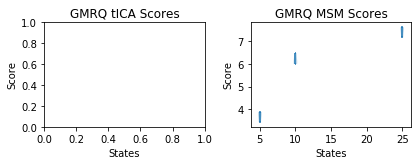

In [22]:
# GMRQ

scores = []
states = [5,10,25]
for i in tqdm.tqdm_notebook(range(len(states))):
    for j in tqdm.tqdm_notebook(range(3),leave=False):
        scores.append([states[i]])
        n_clusters = states[i]
        tica_score = compute_tica_components()
        msm_score = compute_msm()
        scores[-1].append(tica_score)
        scores[-1].append(msm_score)
       # scores[i].append(ContiniousTimeMSM.score(sequences=sequences))
        
scores = np.asarray(scores)

fig = plt.figure()
ax1 = fig.add_subplot(221)
tICY=[[scores[x][1] for x in range(len(scores)) if scores[x][0] == states[y]] for y in range(len(states))]
#ax1.violinplot(dataset=tICY,positions=states)
#ax1.violinplot(X,tICY)
ax1.set_xlabel('States')
ax1.set_ylabel('Score')
ax1.title.set_text('GMRQ tICA Scores')

ax2 = fig.add_subplot(222)
MSMY=[[scores[x][2] for x in range(len(scores)) if scores[x][0] == states[y]] for y in range(len(states))]
ax2.violinplot(dataset=MSMY,positions=states)
ax2.set_xlabel('States')
ax2.set_ylabel('Score')
ax2.title.set_text('GMRQ MSM Scores')

#ax3 = fig.add_subplot(223)
#ax3.violinplot(X,CTMSMY)
#ax3.set_xlabel('States')
#ax3.set_ylabel('Score')
#ax3.title.set_text('GMRQ CTMSM Scores')

fig.tight_layout()
fig.show()

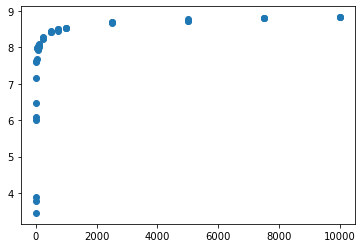

In [30]:
x = [5,5,5,10,10,10,25,25,25,50,50,50,75,75,75,100,100,100,250,250,250,500,500,500,750,750,750,1000,1000,1000,2500,2500,2500,5000,5000,5000,7500,7500,7500,10000,10000,10000]
y = [3.439,3.780,3.885,6.478,5.995,6.092,7.167,7.594,7.617,7.985,7.689,7.997,7.951,7.941,8.047,8.072,8.021,8.108,8.241,8.255,8.283,8.431,8.434,8.464,8.464,8.503,8.499,8.544,8.544,8.525,8.689,8.668,8.701,8.733,8.771,8.726,8.813, 8.800, 8.811, 8.842, 8.845, 8.827]
plt.scatter(x,y)

In [62]:
u_kn, N_k = compute_ukn()
mbar = MBAR(u_kn,N_k,verbose=True)
bin_min = 0.0
bin_max = 1.0 # these are distances?
dx=(bin_max-bin_min)/n_clusters
pmf_distances=np.arange(bin_min,bin_max+dx,dx)
nbins = len(pmf_distances)
########################################################
distance = np.load('distance_99_100.npy')
dis = []
for i in range(len(distance)):
    for j in distance[i]:
        dis.append(j)
dis = np.array(dis)
reshape_dis = dis.reshape(1,u_kn.shape[1])
K = u_kn.shape[0]
nsnaps = distance.shape[-1]
N_k = np.array(K*[nsnaps])
u_kn -= u_kn.min()
bin_kn = np.zeros(reshape_dis.shape,np.int64)
G=[]
mbar = MBAR(u_kn, N_k, verbose=True)
for j in range(2):
    print j
    (f_i, df_i) = mbar.computePMF(u_kn[j], bin_kn, nbins)
    G.append(f_i)
    print f_i, df_i
    fout = open('mbar_%d_sub.dat'%(j),'w')
    fout.write('# distance (nm)\tf (kT)\tdf (kT)\n')
    for i in range(nbins):
        fout.write("%8.4f\t%8.4f\t%8.4f\n" % (pmf_distances[i], f_i[i], df_i[i]) )
    fout.close()
    print 'Wrote'
np.save('raw_G.npy',G)
###############################################

K (total states) = 21, total samples = 137604
N_k = 
[6917 6450 7230 7359 7052 7166 7027 6917 6990 6735 6852 6738 6852 6892 6237
 7090 6871 7155 6711 6363    0]
There are 20 states with samples.
Initializing free energies to zero.
Initial dimensionless free energies with method zeros
f_k = 
[ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.]
Final dimensionless free energies
f_k = 
[  0.          13.96688891  26.23346079  36.88345144  45.95602291
  53.38560619  59.11469852  63.26850613  66.00361937  67.39679509
  67.49070557  66.33976738  64.01382604  60.57926592  56.08753269
  50.57681633  44.07703701  36.61032038  28.18335286  18.76481094
  43.003483  ]
MBAR initialization complete.


In [44]:
################ subsample / autocorrelation #################

from pymbar.timeseries import detectEquilibration
from pymbar.timeseries import statisticalInefficiency

#%ls tram/umbrella_distances/

print('RUN\tAvgSteps\tEquilSteps\tStatIneff\tnUncSamples\tAutocorrelation')
for k in range(K):
    t_k, g_k, Nunc_k, autocorr = [],[],[],[]
    k_distances = np.loadtxt('tram/umbrella_distances/run_%d_dists.dat'%k)
    for l in range(100):
        A_t = np.asarray([x[2] for x in k_distances if x[1] == l])
        if A_t.size != 0:
            autocorr.append(statisticalInefficiency(A_t,A_t))
            indices = detectEquilibration(A_t) # [t, g, Neff_max]
            t_k.append(indices[0])
            g_k.append(indices[1])
            Nunc_k.append(indices[2])
    
    print('%d\t%d\t\t%.3f\t\t%.3f\t\t%d\t\t%.3f'%(k,len(k_distances)/100,np.mean(t_k),np.mean(g_k),np.mean(Nunc_k),np.mean(autocorr)))
                            


RUN	AvgSteps	EquilSteps	StatIneff	nUncSamples	Autocorrelation
0	3458		2.979		1.054		46		1.049
1	3225		0.340		1.032		49		1.027
2	3615		1.926		1.218		42		1.272
3	3679		2.691		1.051		46		1.016
4	3526		1.213		1.157		45		1.107
5	3583		3.957		1.083		44		1.138
6	3513		2.043		1.089		46		1.161
7	3458		4.309		1.175		41		1.361
8	3495		11.511		1.255		33		1.353
9	3367		4.649		1.282		38		1.206
10	3426		14.489		1.571		25		1.724
11	3369		1.723		1.095		46		1.091
12	3426		2.266		1.162		43		1.056
13	3446		4.170		1.081		44		1.336
14	3118		3.521		1.251		39		1.113
15	3545		7.394		1.446		33		1.731
16	3435		4.723		1.385		37		1.192
17	3577		2.181		1.153		44		1.120
18	3355		3.468		1.319		39		1.283
19	3181		4.085		1.236		40		1.111


In [58]:
# GMRQ for state decomposition
# states excluded because of ergotic trimming (if i > j but j !> i, j gets lumped to i)
# d tram can be faster if you calculate free energies first with MBAR and use those as biases
# use state index as bin index for pmf, you will have a pmf for each ensemble, the bias is the pmf
# pmf === free energies
#vpyemma has a built-in function for bias with estimate_umbrella_sampling
# don't add extra sample, add extra ensemble with no bias for K=k
# for its error bars do split into a few clones at a time (same amounts of data tho)

In [128]:
    infile = sorted(glob.glob(project_title + '/traj_data/RUN0/P*R0_C0*'))[0]
    traj = md.load(infile,top=structure_file)
    print('unstrided traj frames',traj.n_frames)
    print('strided traj frames',len(range(traj.n_frames)[equil_steps:][::stride]))
    
    infile = '%s/umbrella_distances/run_0_dists.dat'%(project_title)
    distances = np.loadtxt(infile)
    strided_distances = distances[equil_steps:][::stride]
    clone0 = [x for x in distances if x[0] == 0]
    strided_clone0 = [x for x in strided_distances if x[0] == 0]
    print('unstrided distances',len(clone0))
    print('strided distances',len(strided_clone0))
    
    infile = sorted(glob.glob(project_title + '/features/P*R0_C0*'))[0]
    distances = np.load(infile)
    print('strided npy',np.shape(distances))

    

unstrided traj frames 7876
strided traj frames 157
unstrided distances 7876
strided distances 157
strided npy (157, 84)


In [8]:
import tmap as tm
from faerun import Faerun
import numpy as np
from annoy import AnnoyIndex
from scipy.spatial.distance import cosine as cosine_distance

tica_file = project_title + '/tica/' + 'tica_coords-lag_%d-comp_%d.npy' %(tica_lagtime, n_components)
tica_coordinates = np.load(tica_file, allow_pickle=True)
data = np.concatenate(tica_coordinates, axis=0)[0:1000]

print(np.shape(data))
d = len(data[0])

sources = []
for i, e in enumerate(data):
    sources.extend([i] * len(e))

# Initialize a new Annoy object and index it using 10 trees
annoy = AnnoyIndex(d, metric="angular")
for i, v in enumerate(data):
    annoy.add_item(i, v)
annoy.build(8)

# Create the k-nearest neighbor graph (k = 10)
edge_list = []
for i in range(len(data)):
    for j in annoy.get_nns_by_item(i, 8):
        edge_list.append((i, j, cosine_distance(data[i], data[j])))

    # Compute the layout from the edge list
    x, y, s, t, _ = tm.layout_from_edge_list(len(data), edge_list)

    legend_labels = ['tic%d' for d in range(8)]

    # Create the plot
    faerun = Faerun(
        view="front",
        coords=False,
        legend_title="RNA Flow Cytometry: evaluation of detection sensitivity in low abundant intracellular RNA ",
    )
    faerun.add_scatter(
        "CYTO",
        {"x": x, "y": y, "c": sources, "labels": sources},
        point_scale=1.0,
        max_point_size=10,
        shader="smoothCircle",
        colormap="Set1",
        has_legend=True,
        categorical=True,
        legend_labels=legend_labels,
        legend_title="Cell Types",
    )
    faerun.add_tree(
        "CYTO_tree", {"from": s, "to": t}, point_helper="CYTO", color="#222222"
    )

    faerun.plot("cyto")


(1000, 8)


ValueError: too many values to unpack (expected 2)

In [67]:
project_title = 'PROJ14102'
feature_files = []
for i in range(runs):
    feature_files += sorted(glob.glob(project_title + '/features/' + "P*R%d_*npy"%i))
features = [ np.load(filename) for filename in feature_files]
print(feature_files)

['PROJ14102/features/P14102_R0_C0.npy', 'PROJ14102/features/P14102_R0_C1.npy', 'PROJ14102/features/P14102_R0_C10.npy', 'PROJ14102/features/P14102_R0_C11.npy', 'PROJ14102/features/P14102_R0_C12.npy', 'PROJ14102/features/P14102_R0_C13.npy', 'PROJ14102/features/P14102_R0_C14.npy', 'PROJ14102/features/P14102_R0_C15.npy', 'PROJ14102/features/P14102_R0_C16.npy', 'PROJ14102/features/P14102_R0_C17.npy', 'PROJ14102/features/P14102_R0_C18.npy', 'PROJ14102/features/P14102_R0_C19.npy', 'PROJ14102/features/P14102_R0_C2.npy', 'PROJ14102/features/P14102_R0_C20.npy', 'PROJ14102/features/P14102_R0_C21.npy', 'PROJ14102/features/P14102_R0_C22.npy', 'PROJ14102/features/P14102_R0_C23.npy', 'PROJ14102/features/P14102_R0_C24.npy', 'PROJ14102/features/P14102_R0_C28.npy', 'PROJ14102/features/P14102_R0_C29.npy', 'PROJ14102/features/P14102_R0_C3.npy', 'PROJ14102/features/P14102_R0_C32.npy', 'PROJ14102/features/P14102_R0_C34.npy', 'PROJ14102/features/P14102_R0_C35.npy', 'PROJ14102/features/P14102_R0_C36.npy', 'PR

In [23]:
print(project_title)

PROJ14106
